# 🌀 Hurricane Ian WRF Analysis (No WRF-Python)
This notebook performs hurricane center detection and analysis **without using `wrf-python`**.

Steps:
1. Load WRF data.
2. Find the hurricane center from pressure, wind, and computed vorticity.
3. Create a vortex-centered coordinate system.
4. Compute radial and tangential wind components.
5. Plot results.

In [42]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from pyproj import Proj, Transformer
from pathlib import Path

## 1️⃣ Load WRF Dataset

In [52]:
data_path = Path('data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]
print(f"Loaded WRF file with shape: {lat.shape}")

print(len(ds.dimensions['Time']))
t = 50

Loaded WRF file with shape: (717, 669)
73


## 2️⃣ Find Hurricane Center (Surface Pressure Minimum)

In [51]:
for test_t in range(0, 73, 5):  # Test every 5th timestep
    try:
        psfc_test = ds.variables['PSFC'][test_t, :, :]
        print(f"Timestep {test_t} loaded successfully.")
    except RuntimeError as e:
        print(f"Timestep {test_t} failed: {e}")
        break

Timestep 0 loaded successfully.
Timestep 5 failed: NetCDF: HDF error


In [60]:
t = 69

psfc = ds.variables['PSFC'][t, :, :] / 100  # Pa → hPa
imin = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat_psfc, center_lon_psfc = float(lat[imin]), float(lon[imin])
print(f"Center (min PSFC): {center_lat_psfc:.2f}°, {center_lon_psfc:.2f}°")

Center (min PSFC): 26.71°, -83.75°


## 3️⃣ Compute Approximate 850-hPa Vorticity Without `wrf-python`

In [61]:
# Approximate relative vorticity from 10-m winds for demonstration
u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]
deg2m = 111000  # rough conversion (1 degree ~ 111 km)
dy, dx = np.gradient(lat * deg2m, axis=0), np.gradient(lon * deg2m, axis=1)
dVdx = np.gradient(v10, axis=1) / (dx + 1e-9)
dUdy = np.gradient(u10, axis=0) / (dy + 1e-9)
f = 2 * 7.2921e-5 * np.sin(np.deg2rad(lat))  # Coriolis parameter
vort = dVdx - dUdy + f
imax = np.unravel_index(np.argmax(vort), vort.shape)
center_lat_vort, center_lon_vort = float(lat[imax]), float(lon[imax])
print(f"Center (max vorticity): {center_lat_vort:.2f}°, {center_lon_vort:.2f}°")

Center (max vorticity): 27.11°, -83.90°


## 4️⃣ Find Hurricane Center (10-m Wind Speed Minimum)

In [62]:
wind_speed = np.sqrt(u10**2 + v10**2)
imin_ws = np.unravel_index(np.argmin(wind_speed), wind_speed.shape)
center_lat_ws, center_lon_ws = float(lat[imin_ws]), float(lon[imin_ws])
print(f"Center (min 10-m wind): {center_lat_ws:.2f}°, {center_lon_ws:.2f}°")

Center (min 10-m wind): 28.08°, -82.58°


## 5️⃣ Create Vortex-Centered Azimuthal Equidistant Projection

In [63]:
center_lat, center_lon = center_lat_psfc, center_lon_psfc
aeqd = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')
transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
x, y = transformer.transform(lon, lat)
r = np.sqrt(x**2 + y**2) / 1000  # km
theta = np.degrees(np.arctan2(y, x))
print('Computed storm-centered r and θ grids.')

Computed storm-centered r and θ grids.


## 6️⃣ Compute Radial and Tangential Wind Components

In [64]:
radial_wind =  u10 * np.cos(np.radians(theta)) + v10 * np.sin(np.radians(theta))
tangential_wind = -u10 * np.sin(np.radians(theta)) + v10 * np.cos(np.radians(theta))
print('Radial and tangential components computed.')

Radial and tangential components computed.


## 7️⃣ Plot Wind Speed, Vectors, and Center

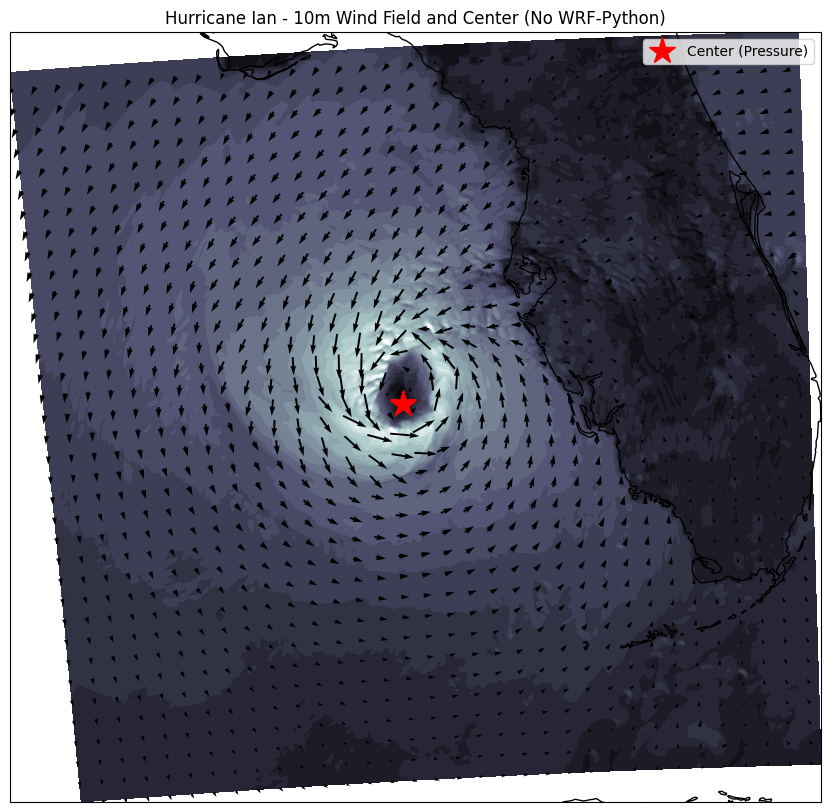

In [65]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone')
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500)
ax.plot(center_lon, center_lat, 'r*', markersize=20, label='Center (Pressure)')
plt.legend()
plt.title('Hurricane Ian - 10m Wind Field and Center (No WRF-Python)')
plt.show()

In [68]:
# Earth's radius (m) - used for perturbation, but h~0
a = 6371000.0  # Approximate, datum WGS84

# Number of levels for inflow (bottom 10, ~0-2km typically)
num_levels = 10

# Load U and V for selected timestep t (use t=0 due to HDF error beyond t=4)
t = 0  # Adjust if other timesteps work after file fix
u_stag = ds.variables['U'][t, :num_levels, :, :]  # shape: (10, 717, 670)
v_stag = ds.variables['V'][t, :num_levels, :, :]  # shape: (10, 718, 669)

# Destagger U: average over west_east_stag to west_east
u = 0.5 * (u_stag[:, :, :-1] + u_stag[:, :, 1:])  # (10, 717, 669)

# Destagger V: average over south_north_stag to south_north
v = 0.5 * (v_stag[:, :-1, :] + v_stag[:, 1:, :])  # (10, 717, 669)

print(f"Destaggered U and V for {num_levels} levels: {u.shape}")

Destaggered U and V for 10 levels: (10, 717, 669)


In [69]:
# Compute approximate heights (m) at mass points for each level
g = 9.81
ph = ds.variables['PH'][t, :num_levels+1, :, :]  # (11, 717, 669) - top stag for bottom 10 levels
phb = ds.variables['PHB'][t, :num_levels+1, :, :]  # Same
z_stag = (ph + phb) / g  # Geopotential height on w-levels (11, 717, 669)

# Average to mass points (bottom 10 levels)
z = 0.5 * (z_stag[:-1, :, :] + z_stag[1:, :, :])  # (10, 717, 669)

# Domain-mean height per level (for labeling)
mean_heights = np.mean(z, axis=(1, 2))
print(f"Mean heights (m) for bottom {num_levels} levels: {mean_heights}")

Mean heights (m) for bottom 10 levels: [30.19406496599511 90.62126572170853 167.6098768974384 265.18792935349285
 388.01494373678116 541.3057338377001 730.6371564091495 961.6020178479517
 1239.372948309628 1568.092104325456]


In [70]:
# Precompute lat/lon in radians for cos(phi)
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)  # lon, lat are (717, 669)

# Epsilon for perturbation (small central angle, radians)
epsilon = 1e-6

# Initialize Vr array
vr = np.zeros_like(u)  # (10, 717, 669)

# Loop over levels (vectorize where possible)
for k in range(num_levels):
    wind_speed = np.sqrt(u[k]**2 + v[k]**2)
    mask = wind_speed > 0  # Avoid div by zero
    
    # Directions (unit vectors)
    du = np.zeros_like(u[k])
    dv = np.zeros_like(v[k])
    du[mask] = u[k][mask] / wind_speed[mask]
    dv[mask] = v[k][mask] / wind_speed[mask]
    
    # Perturbed positions
    lon_prime = lon + (epsilon * du / np.cos(lat_rad))
    lat_prime = lat + (epsilon * dv)
    
    # Transform perturbed to AEQD
    x_prime, y_prime = transformer.transform(lon_prime, lat_prime)
    
    # Delta
    dx = x_prime - x
    dy = y_prime - y
    
    # Alpha (degrees)
    alpha = np.degrees(np.arctan2(dy, dx))
    alpha[~mask] = 0  # Arbitrary for zero wind
    
    # Vr = |V| * cos(theta - alpha)  (positive outward)
    delta_angle = np.deg2rad(theta - alpha)
    vr[k][mask] = wind_speed[mask] * np.cos(delta_angle[mask])
    vr[k][~mask] = 0

print("Computed Vr (positive outward). Inflow where Vr < 0.")

Computed Vr (positive outward). Inflow where Vr < 0.


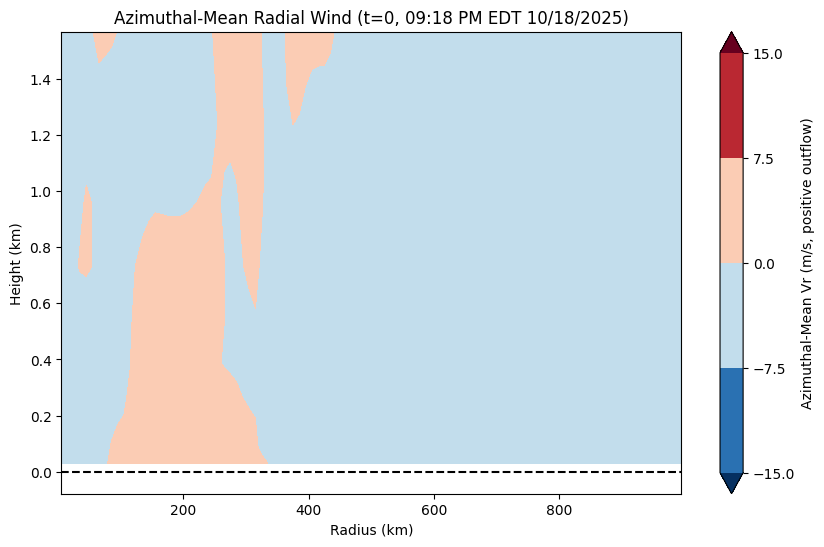

In [75]:
# Bin radii for azimuthal means (0-1000 km, 10 km bins)
r_bins = np.arange(0, 1001, 10)
r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

# Initialize mean Vr (height, radius_bin)
mean_vr = np.zeros((num_levels, len(r_centers)))

for k in range(num_levels):
    for bin_idx in range(len(r_bins) - 1):
        mask = (r >= r_bins[bin_idx]) & (r < r_bins[bin_idx + 1])
        if np.any(mask):
            mean_vr[k, bin_idx] = np.mean(vr[k][mask])

# Plot azimuthal-mean Vr (inflow negative)
fig, ax = plt.subplots(figsize=(10, 6))
heights_grid, r_grid = np.meshgrid(mean_heights / 1000, r_centers)  # Heights in km
c = ax.contourf(r_grid.T, heights_grid.T, mean_vr, levels=np.linspace(-15, 15, 5), cmap='RdBu_r', extend='both')
plt.colorbar(c, label='Azimuthal-Mean Vr (m/s, positive outflow)')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Height (km)')
ax.set_title(f'Azimuthal-Mean Radial Wind (t={t}, 09:18 PM EDT 10/18/2025)')
ax.axhline(0, color='k', linestyle='--')  # Zero line
plt.show()